In [24]:
from pathlib import Path

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm # For display

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from dataset import get_fashion_mnist_dataset

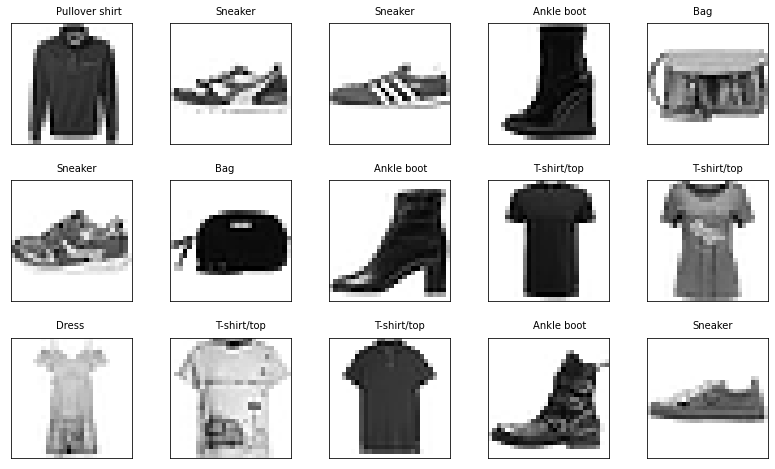

In [30]:
# Load the dataset

(x_train, y_train), (x_test, y_test), train_dataset, test_dataset = get_fashion_mnist_dataset(one_hot=False,
                                                                                            batch_size=64, 
                                                                                            shuffle=True, 
                                                                                            buffer_size=1000)
# Display a few examples

class_names = np.array(['T-shirt/top', 'Trouser/pants', 'Pullover shirt', 'Dress',
                        'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag','Ankle boot'])

n_rows, n_cols = 3, 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 8))
inx = np.random.choice(x_train.shape[0], n_rows*n_cols, replace=False)
fig.subplots_adjust(hspace=0.3, wspace=0.1)

for n, (image, label) in enumerate(zip(x_train[inx], y_train[inx])):
    row = n // n_cols
    col = n % n_cols
    axes[row, col].imshow(image, cmap='binary')
    axes[row, col].get_xaxis().set_visible(False)
    axes[row, col].get_yaxis().set_visible(False)
    axes[row, col].text(10., -2.5, f'{class_names[label]}')
plt.show()

# Training only the encoder with a cross entropy loss

In [5]:
# Load the dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train = x_train/255.
x_test = x_test/255.

# Add channel axis
print(x_train.shape)
x_train = x_train[..., np.newaxis]
print(x_train.shape)

# Convert labels to one-hot
print(y_test[:3])
y_test = tf.one_hot(indices=y_test, depth=10).numpy()
y_train = tf.one_hot(indices=y_train, depth=10).numpy()
print(y_test[:3])

(60000, 28, 28)
(60000, 28, 28, 1)
[9 2 1]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [6]:
encoded_dim = 2
classes_dim = 10

encoder = Sequential([
    Conv2D(16, 5, activation='relu', input_shape=(28,28,1)),
    MaxPool2D(2),
    Conv2D(8, 5, activation='relu'),
    Flatten(),
    # Dense(64, activation=None),
    Dense(encoded_dim, activation=None)
])

final_layer = Sequential([
    Dense(classes_dim, activation='softmax', input_shape=(encoded_dim,))
])

model = Model(inputs=encoder.input, outputs=final_layer(encoder.output))

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 24, 24, 16)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 8)           3208      
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 2)                 1026      
                                                             

In [7]:
# Compute encodings before training
inx = np.random.choice(x_test.shape[0], 1000, replace=False)

untrained_encodings = encoder(x_test[inx]).numpy()
untrained_encoding_labels = y_test[inx]

In [8]:
# Create Dataset objects for train and test sets

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Process the datasets

train_dataset = train_dataset.shuffle(1000)
train_dataset = train_dataset.batch(64).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(64).prefetch(tf.data.experimental.AUTOTUNE)

### Custom loss

In [ ]:
def softmax_loss(y_true, y_pred):
        y_true = tf.cast(tf.reshape(y_true, [-1]), tf.int32)
        ce = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true,
                                                            logits=y_pred)
        return tf.reduce_mean(ce)

In [10]:
# Compile and fit the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=5e-3))
model.fit(train_dataset, epochs=10)

Epoch 1/10
938/938 [==============================] - 17s 17ms/step - loss: 0.8275
Epoch 2/10
938/938 [==============================] - 15s 16ms/step - loss: 0.5972
Epoch 3/10
938/938 [==============================] - 15s 16ms/step - loss: 0.5421
Epoch 4/10
938/938 [==============================] - 15s 16ms/step - loss: 0.5026
Epoch 5/10
938/938 [==============================] - 15s 16ms/step - loss: 0.4788
Epoch 6/10
938/938 [==============================] - 16s 17ms/step - loss: 0.4570
Epoch 7/10
938/938 [==============================] - 16s 17ms/step - loss: 0.4437
Epoch 8/10
938/938 [==============================] - 16s 17ms/step - loss: 0.4288
Epoch 9/10
938/938 [==============================] - 17s 18ms/step - loss: 0.4201
Epoch 10/10
938/938 [==============================] - 15s 17ms/step - loss: 0.4118


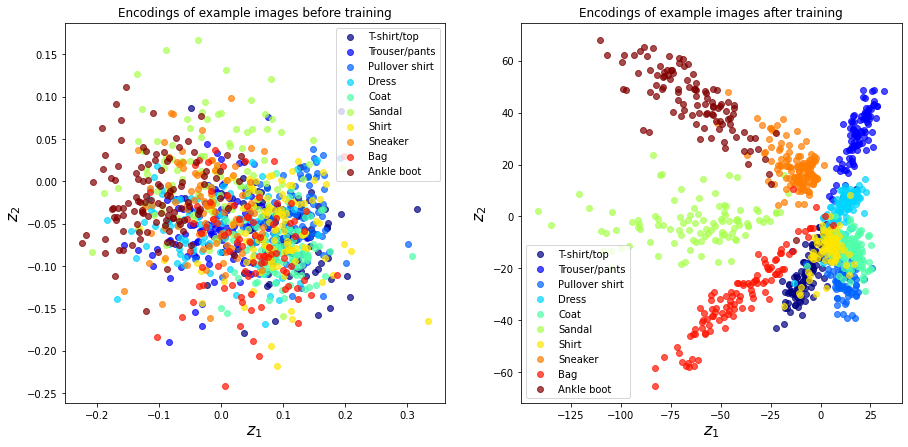

In [11]:
# Compute encodings after training
inx = np.random.choice(x_test.shape[0], 1000, replace=False)
trained_encodings = encoder(x_test[inx]).numpy()
trained_encoding_labels = y_test[inx]

# Un-one-hot labels
trained_encoding_labels_restacked = np.argmax(trained_encoding_labels, axis=1)
untrained_encoding_labels_restacked = np.argmax(untrained_encoding_labels, axis=1)

# Plot untrained and trained encodings

plt.figure(figsize=(15, 7))
cmap = cm.get_cmap('jet', 10)

plt.subplot(1, 2, 1)
for i, class_label in enumerate(class_names):
    inx = np.where(untrained_encoding_labels_restacked == i)[0]
    plt.scatter(untrained_encodings[inx, 0], untrained_encodings[inx, 1],
                color=cmap(i), label=class_label, alpha=0.7)
plt.xlabel('$z_1$', fontsize=16) 
plt.ylabel('$z_2$', fontsize=16)
plt.title('Encodings of example images before training')
plt.legend()

plt.subplot(1, 2, 2)
for i, class_label in enumerate(class_names):
    inx = np.where(trained_encoding_labels_restacked == i)[0]
    plt.scatter(trained_encodings[inx, 0], trained_encodings[inx, 1],
                color=cmap(i), label=class_label, alpha=0.7)
plt.xlabel('$z_1$', fontsize=16) 
plt.ylabel('$z_2$', fontsize=16)
plt.title('Encodings of example images after training')
plt.legend()

plt.show()

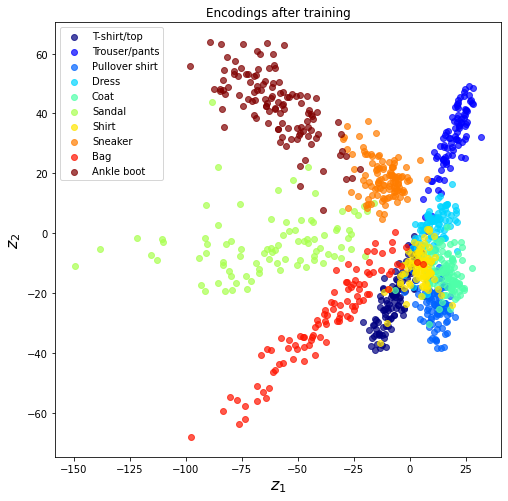

In [13]:
# Compute encodings after training
inx = np.random.choice(x_test.shape[0], 1000, replace=False)
trained_encodings = encoder(x_test[inx]).numpy()
trained_encoding_labels = y_test[inx]

# Un-one-hot labels
trained_encoding_labels_restacked = np.argmax(trained_encoding_labels, axis=1)
untrained_encoding_labels_restacked = np.argmax(untrained_encoding_labels, axis=1)

plt.figure(figsize=(8, 8))
cmap = cm.get_cmap('jet', 10)

for i, class_label in enumerate(class_names):
    inx = np.where(trained_encoding_labels_restacked == i)[0]
    plt.scatter(trained_encodings[inx, 0], trained_encodings[inx, 1],
                color=cmap(i), label=class_label, alpha=0.7)
plt.xlabel('$z_1$', fontsize=16) 
plt.ylabel('$z_2$', fontsize=16)
plt.title('Encodings after training')
plt.legend()

plt.show()

In [28]:
y_true = y_test[0]
y_true

9

In [29]:
y_true = tf.cast(tf.reshape(y_true, [-1]), tf.int32)
y_true

<tf.Tensor: shape=(1,), dtype=int32, numpy=array([9])>

In [ ]:
ce = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true,
                                                            logits=y_pred)